# SDG 11.2.1 (mh edit)

## 11.2.1
Proportion of population that has convenient access to public transport, by sex, age and persons with disabilities 

**11.2.1 is under 11.2**

## 11.2
By 2030, provide access to safe, affordable, accessible and sustainable transport systems for all, improving road safety, notably by expanding public transport, with special attention to the needs of those in vulnerable situations, women, children, persons with disabilities and older persons 


Method
<ol>
1) get public transport location data - NAPTAN a) Clean it if necessary
2) get population location data -  LSOA from ONS
3) use Fiona to read location data
4) limit to one or two locations, e.g. London and a more rural area
5) draw Euclidean Buffers around LSOA polygon centre points
6) find number of public transport stops in the polygon with “points in polygons” approach
</ol>

In [91]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt 
from shapely.geometry import Point, Polygon

In [92]:
## Extracted the Stops.txt file. 
## Making into a Pandas dataframe

# Have changed how you call files as to not have local folder names (this will now work for whoever uses the code)
stops_df = pd.read_csv(os.path.join(os.getcwd(), 'data','Stops.txt'), delimiter='\t')
stops_df.sample(15)

,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,vehicle_type
46711,100000018890,dbsadmdp,"Kirk Hallam, St John Houghton School (adj)",52.96370,-1.32997,NaN,3.0
146269,2500DCL5744,landmpma,"Alkincoats, Alkincoats Road (by)",53.85781,-2.18222,NaN,3.0
168408,2800S40132B,merdapdp,"Kirkdale, Virgil Street (adj)",53.41932,-2.97824,NaN,3.0
69999,13006793C,durdtdpd,"Ferryhill, Linden Road (E-bound)",54.68415,-1.53642,NaN,3.0
220097,3800C316802,stadawja,"Branston, Bridgford Avenue (Opp)",52.78996,-1.66649,NaN,3.0
228122,390070967,sufjmtgj,"All Saints South Elmham, Shelter (opp)",52.39128,1.43901,NaN,3.0
176446,2900T0435,NFODWMPW,"Thorpe Marriott, Castle Rise (opp)",52.68932,1.21249,NaN,3.0
84091,1590030301,thudjtd,"Orsett, Heath Road (SW-bound)",51.49837,0.35729,NaN,3.0
298313,490008496E,57060,"Central Hounslow, Heath Road Hounslow (Stop SB)",51.46382,-0.36065,NaN,3.0
331004,5710LLISHEN0,NaN,"Llanishen, Llanishen Rail Station (Main Entrance)",51.53264,-3.18189,NaN,NaN


In [93]:
def make_geo_df(df,col_x, col_y):
    """A function to create a geodataframe from a datafrom. Supply the dataframe, and the names of lon and lat columns."""
    geometry = [Point(xy) for xy in zip(df[col_x], df[col_y])]
    geo_df = gpd.GeoDataFrame(df, geometry=geometry)
    return geo_df

In [94]:
## Creating the GeoDataframe version of stops_df
stops_geo_df = make_geo_df(stops_df,'stop_lon','stop_lat')

stops_geo_df.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,vehicle_type,geometry
0,0100BRP90207,bstmdat,"Eastville, Royate Hill (W-bound)",51.47309,-2.55061,NaN,3.0,POINT (-2.55061 51.47309)
1,0100BRP90210,bstjwgd,"Eastville, Glen Park (SW-bound)",51.47164,-2.56021,NaN,3.0,POINT (-2.56021 51.47164)
2,0100BRA16910,bstpagj,"Bristol City Centre, Rupert Street (Hf)",51.45680,-2.59457,NaN,3.0,POINT (-2.59457 51.45680)
3,0100BRA16911,bstpaga,"Bristol City Centre, Rupert Street (Hg)",51.45674,-2.59490,NaN,3.0,POINT (-2.59490 51.45674)
4,0100BRP90080,bstjagp,"St Andrews, Ashley Park (SW-bound)",51.47248,-2.58268,NaN,3.0,POINT (-2.58268 51.47248)


In [95]:
## Set CRS to 4326

stops_geo_df.crs = "EPSG:4326"
stops_geo_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [96]:
## Getting a sample of the new geo_df

stops_geo_df.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,vehicle_type,geometry
0,0100BRP90207,bstmdat,"Eastville, Royate Hill (W-bound)",51.47309,-2.55061,NaN,3.0,POINT (-2.55061 51.47309)
1,0100BRP90210,bstjwgd,"Eastville, Glen Park (SW-bound)",51.47164,-2.56021,NaN,3.0,POINT (-2.56021 51.47164)
2,0100BRA16910,bstpagj,"Bristol City Centre, Rupert Street (Hf)",51.45680,-2.59457,NaN,3.0,POINT (-2.59457 51.45680)
3,0100BRA16911,bstpaga,"Bristol City Centre, Rupert Street (Hg)",51.45674,-2.59490,NaN,3.0,POINT (-2.59490 51.45674)
4,0100BRP90080,bstjagp,"St Andrews, Ashley Park (SW-bound)",51.47248,-2.58268,NaN,3.0,POINT (-2.58268 51.47248)


In [97]:
# Load Greater London polygon and check CRS is 4326

greater_london = gpd.read_file(os.path.join(os.getcwd(), 'data','greater_london.geojson'))
greater_london.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [98]:
# Find points in polygon using geopandas (you need to install rtree 'pip install rtree')

# Join points and polygons

london_stops_geo_df = gpd.sjoin(stops_geo_df, greater_london, how='left', op='within')
london_stops_geo_df.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,vehicle_type,geometry,index_right,id,EER13CD,EER13CDO,EER13NM
0,0100BRP90207,bstmdat,"Eastville, Royate Hill (W-bound)",51.47309,-2.55061,NaN,3.0,POINT (-2.55061 51.47309),NaN,NaN,NaN,NaN,NaN
1,0100BRP90210,bstjwgd,"Eastville, Glen Park (SW-bound)",51.47164,-2.56021,NaN,3.0,POINT (-2.56021 51.47164),NaN,NaN,NaN,NaN,NaN
2,0100BRA16910,bstpagj,"Bristol City Centre, Rupert Street (Hf)",51.45680,-2.59457,NaN,3.0,POINT (-2.59457 51.45680),NaN,NaN,NaN,NaN,NaN
3,0100BRA16911,bstpaga,"Bristol City Centre, Rupert Street (Hg)",51.45674,-2.59490,NaN,3.0,POINT (-2.59490 51.45674),NaN,NaN,NaN,NaN,NaN
4,0100BRP90080,bstjagp,"St Andrews, Ashley Park (SW-bound)",51.47248,-2.58268,NaN,3.0,POINT (-2.58268 51.47248),NaN,NaN,NaN,NaN,NaN


In [99]:
# Drop all rows where index_right is NaN, that is, where the point is not in the polygon

london_stops_geo_df = london_stops_geo_df[london_stops_geo_df['index_right'].notna()]
london_stops_geo_df.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,vehicle_type,geometry,index_right,id,EER13CD,EER13CDO,EER13NM
76301,150012891S,esxjdtjp,"Grange Hill, Stradbroke Park (adj)",51.60482,0.07290,NaN,3.0,POINT (0.07290 51.60482),0.0,E15000007,E15000007,07,London
79876,150042023001,esxatmga,"Grange Hill, Tudor Crescent (adj)",51.60665,0.08303,NaN,3.0,POINT (0.08303 51.60665),0.0,E15000007,E15000007,07,London
122161,210021803340,hrtajatj,"Batchworth Heath, Mount Vernon Hospital (nr)",51.61460,-0.45066,NaN,3.0,POINT (-0.45066 51.61460),0.0,E15000007,E15000007,07,London
123431,210021001322,hrtgtdad,"Dancers Hill, The Shires (nr)",51.66453,-0.20933,NaN,3.0,POINT (-0.20933 51.66453),0.0,E15000007,E15000007,07,London
134927,2400107805,kntjwmdj,"Knockholt, Scotts Lodge (opp)",51.30058,0.08625,NaN,3.0,POINT (0.08625 51.30058),0.0,E15000007,E15000007,07,London


In [100]:
# Drop all row names from join (so we can reuse)

london_stops_geo_df=london_stops_geo_df[stops_geo_df.columns.to_list()]
london_stops_geo_df

,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,vehicle_type,geometry
76301,150012891S,esxjdtjp,"Grange Hill, Stradbroke Park (adj)",51.60482,0.07290,NaN,3.0,POINT (0.07290 51.60482)
79876,150042023001,esxatmga,"Grange Hill, Tudor Crescent (adj)",51.60665,0.08303,NaN,3.0,POINT (0.08303 51.60665)
122161,210021803340,hrtajatj,"Batchworth Heath, Mount Vernon Hospital (nr)",51.61460,-0.45066,NaN,3.0,POINT (-0.45066 51.61460)
123431,210021001322,hrtgtdad,"Dancers Hill, The Shires (nr)",51.66453,-0.20933,NaN,3.0,POINT (-0.20933 51.66453)
134927,2400107805,kntjwmdj,"Knockholt, Scotts Lodge (opp)",51.30058,0.08625,NaN,3.0,POINT (0.08625 51.30058)
...,...,...,...,...,...,...,...,...
383794,9400ZZLUNDN,NaN,"Neasden, Neasden Underground Station",51.55399,-0.24984,NaN,1.0,POINT (-0.24984 51.55399)
383795,9400ZZLUNEN,NaN,"North Ealing, North Ealing Underground Station",51.51750,-0.28887,NaN,1.0,POINT (-0.28887 51.51750)
383796,9400ZZLUNFD,NaN,"Northfields, Northfields Underground Station",51.49932,-0.31472,NaN,1.0,POINT (-0.31472 51.49932)
383799,9400ZZDLPDK,NaN,"Silvertown, Pontoon Dock DLR Station",51.50221,0.03212,NaN,1.0,POINT (0.03212 51.50221)


In [101]:
# Building the map of Local Authority Districts

locAuth_map_df = gpd.read_file(os.path.join(os.getcwd(), 
                                            'data', 
                                            'lad_2017_generalised',
                                            'Local_Authority_Districts_December_2017_Generalised_Clipped_Boundaries_in_United_Kingdom_WGS84.shp'))

### I have also downloaded the output area for London, but am struggling with the CRS
# OA_2011_London_gen_MHW.shp'

In [102]:
## Testing that I can filter based on placename, e.g. Islington

locAuth_map_df[locAuth_map_df['lad17nm']=='Islington']
## works!

,objectid,lad17cd,lad17nm,lad17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
186,312,E09000019,Islington,None,531158,184647,-0.10992,51.5455,0.001923,0.235052,"POLYGON ((-0.11920 51.57465, -0.11879 51.57433..."


In [103]:
# likewise, I can filter on the lad17cd code. I will use the code to filter for places in London
## I was told 'E09' is for London

locAuth_map_df[locAuth_map_df.lad17cd.str.contains('E09')]

,objectid,lad17cd,lad17nm,lad17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
53,298,E09000005,Brent,None,519615,186468,-0.275680,51.5644,0.005603,0.456380,"POLYGON ((-0.26875 51.60087, -0.26136 51.59467..."
98,318,E09000025,Newham,None,540721,183327,0.027369,51.5313,0.004689,0.402297,"POLYGON ((0.05408 51.55984, 0.05471 51.55909, ..."
101,319,E09000026,Redbridge,None,543512,189478,0.070085,51.5859,0.007315,0.550043,"POLYGON ((0.03113 51.62274, 0.03582 51.61882, ..."
103,325,E09000032,Wandsworth,None,525152,174137,-0.200210,51.4524,0.004431,0.456191,"POLYGON ((-0.12797 51.48498, -0.12910 51.48254..."
106,310,E09000017,Hillingdon,None,508166,183120,-0.441820,51.5366,0.014998,0.717381,"POLYGON ((-0.49574 51.63154, -0.49514 51.63105..."
122,326,E09000033,Westminster,None,528268,180871,-0.152950,51.5122,0.002779,0.310957,"POLYGON ((-0.17574 51.53871, -0.17511 51.53814..."
176,311,E09000018,Hounslow,None,512744,174965,-0.378440,51.4624,0.007241,0.720192,"MULTIPOLYGON (((-0.28237 51.50336, -0.27948 51..."
186,312,E09000019,Islington,None,531158,184647,-0.109920,51.5455,0.001923,0.235052,"POLYGON ((-0.11920 51.57465, -0.11879 51.57433..."
188,313,E09000020,Kensington and Chelsea,None,525757,179053,-0.189760,51.4964,0.001572,0.241396,"POLYGON ((-0.22918 51.53066, -0.22928 51.53042..."
195,314,E09000021,Kingston upon Thames,None,519508,167389,-0.283670,51.3930,0.004814,0.404645,"POLYGON ((-0.25271 51.42283, -0.25123 51.41905..."


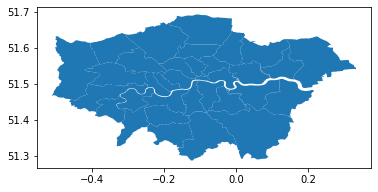

In [104]:
## Making a filtered geo_df of just the places with 'E09' in their string
## rathter than using str.contains, I'll use == instead
lond_districts = locAuth_map_df[locAuth_map_df.lad17cd.str[:3]=='E09']

## PLotting the london districts just to see how it looks
_ = lond_districts.plot()

In [105]:
## checking the new london districts df

lond_districts.head()

,objectid,lad17cd,lad17nm,lad17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
53,298,E09000005,Brent,None,519615,186468,-0.275680,51.5644,0.005603,0.456380,"POLYGON ((-0.26875 51.60087, -0.26136 51.59467..."
98,318,E09000025,Newham,None,540721,183327,0.027369,51.5313,0.004689,0.402297,"POLYGON ((0.05408 51.55984, 0.05471 51.55909, ..."
101,319,E09000026,Redbridge,None,543512,189478,0.070085,51.5859,0.007315,0.550043,"POLYGON ((0.03113 51.62274, 0.03582 51.61882, ..."
103,325,E09000032,Wandsworth,None,525152,174137,-0.200210,51.4524,0.004431,0.456191,"POLYGON ((-0.12797 51.48498, -0.12910 51.48254..."
106,310,E09000017,Hillingdon,None,508166,183120,-0.441820,51.5366,0.014998,0.717381,"POLYGON ((-0.49574 51.63154, -0.49514 51.63105..."


In [106]:
# Make a polygon to border the whole of London
## make a temp dataframe
_ = lond_districts
## make an extra column 'city_name' on which to dissolve on, making them all the same value, 'London'
_.loc[:,'city_name'] = 'London'
# ## make the polygon with dissolve, using city_name
whole_london_poly = _.dissolve(by='city_name')
## Seems like a bit of a bizzare method, but it works, I think

/Users/michaelhodge/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/michaelhodge/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


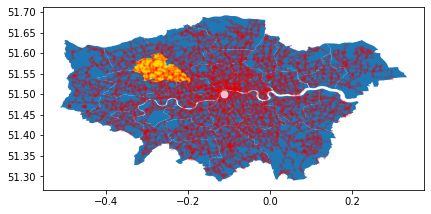

In [107]:
## Making a centroid 
centrepoint = whole_london_poly.centroid

ward = 'Brent'

ward_polygon = lond_districts[lond_districts.lad17nm == ward]
## plot the whole_london_poly polygon 
## with the selected stops laid over it 

fig, ax = plt.subplots()
_ =  lond_districts.plot(ax=ax)
_ = ward_polygon.plot(ax=ax, facecolor='gold')
_ = london_stops_geo_df.plot(ax=ax, color='red', markersize=2, alpha=0.1)
_ = centrepoint.plot(ax=ax, color='pink', markersize=45) ## added the centroid into the plot
plt.tight_layout()

## great, this works!

In [108]:
# Filter for ward

ward_stops_geo_df = gpd.sjoin(london_stops_geo_df, Brent, how='left', op='within')
ward_stops_geo_df.head()

# Drop all rows where id (from polygon) is NaN, that is, where the point is not in the polygon

ward_stops_geo_df = ward_stops_geo_df[ward_stops_geo_df['index_right'].notna()]
ward_stops_geo_df

# Drop all row names from join (so we can reuse)

ward_stops_geo_df = ward_stops_geo_df[stops_geo_df.columns.to_list()]
ward_stops_geo_df

,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,vehicle_type,geometry
289623,490000061A,54094,"Dudden Hill, Dollis Hill (Stop DA)",51.55281,-0.23831,NaN,3.0,POINT (-0.23831 51.55281)
289722,490000005A,55100,"Alperton, Alperton (Stop A)",51.54055,-0.29893,NaN,3.0,POINT (-0.29893 51.54055)
289723,490000005B,57826,"Alperton, Alperton (Stop B)",51.54087,-0.29907,NaN,3.0,POINT (-0.29907 51.54087)
289768,490000061B,71144,"Dudden Hill, Dollis Hill (Stop DB)",51.55271,-0.23940,NaN,3.0,POINT (-0.23940 51.55271)
289879,490000124HH,50244,"Kenton, Kenton Station (Stop HH)",51.58136,-0.31844,NaN,3.0,POINT (-0.31844 51.58136)
...,...,...,...,...,...,...,...,...
383525,9400ZZLUPRD,NaN,"Preston, Preston Road Underground Station",51.57197,-0.29511,NaN,1.0,POINT (-0.29511 51.57197)
383631,9400ZZLUWIG,NaN,"Willesden Green, Willesden Green Underground S...",51.54915,-0.22154,NaN,1.0,POINT (-0.22154 51.54915)
383644,9400ZZLUSKT,NaN,"South Kenton, South Kenton Underground Station",51.57023,-0.30843,NaN,1.0,POINT (-0.30843 51.57023)
383761,9400ZZLUNWY,NaN,"North Wembley, North Wembley Underground Station",51.56255,-0.30400,NaN,1.0,POINT (-0.30400 51.56255)


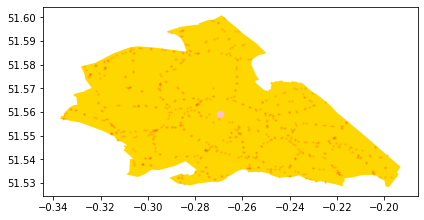

In [72]:
## Making a centroid 
centrepoint = ward_polygon.centroid

fig, ax = plt.subplots()
_ = ward_polygon.plot(ax=ax, facecolor='gold')
_ = ward_stops_geo_df.plot(ax=ax, color='red', markersize=2, alpha=0.1)
_ = centrepoint.plot(ax=ax, color='pink', markersize=45) ## added the centroid into the plot
plt.tight_layout()

## great, this works!